<a href="https://colab.research.google.com/github/ajaysuseel/MiniProject_AD/blob/main/Copy_of_BLIP_finetuned_evaluator_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
import shutil
import os

drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
import json
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
# For metrics
!pip install -q rouge-score
!pip install -q torchmetrics
import nltk
nltk.download('wordnet')

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=3f1d9abba00fde96222ed94762049eb72f7ce97c26f31f0065103b90e64b735a
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import pytorch_lightning as pl

In [ ]:
# tqdm for progress bar
from tqdm import tqdm

# NLTK for BLEU and METEOR scores
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.meteor_score import meteor_score
import nltk
nltk.download('wordnet')  # Download WordNet for METEOR

# ROUGE scorer from rouge_score package
from rouge_score import rouge_scorer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Define your Lightning module (BlipLightning)
class BlipLightning(pl.LightningModule):
    def __init__(self, model_name="Salesforce/blip-image-captioning-base", learning_rate=5e-5, freeze_vision=True, freeze_layers=6):
        """
        freeze_layers: Freeze vision encoder layers with index less than this value.
        If freeze_vision is True, also freeze vision embeddings.
        """
        super().__init__()
        self.model = BlipForConditionalGeneration.from_pretrained(model_name)
        self.processor = BlipProcessor.from_pretrained(model_name, use_fast=True)
        self.learning_rate = learning_rate

        if freeze_vision:
            # Freeze vision embedding layers (all parameters in vision_model.embeddings)
            for name, param in self.model.named_parameters():
                if "vision_model.embeddings" in name:
                    param.requires_grad = False
                    print(f"Freezing vision embedding parameter: {name}")

            # Freeze early vision encoder layers based on layer index
            for name, param in self.model.named_parameters():
                if "vision_model.encoder.layers" in name:
                    parts = name.split(".")
                    try:
                        layer_index = int(parts[3])
                    except (IndexError, ValueError):
                        layer_index = None
                    if layer_index is not None and layer_index < freeze_layers:
                        param.requires_grad = False
                        print(f"Freezing vision encoder layer {layer_index}: {name}")

    def forward(self, pixel_values, input_ids, attention_mask, labels):
        return self.model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

    def training_step(self, batch, batch_idx):
        if batch_idx == 0:
            print("Inside training_step, model.training:", self.training)
        outputs = self(
            pixel_values=batch["pixel_values"],
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

In [ ]:

def load_model_and_processor(checkpoint_path):
    try:
        model = BlipLightning.load_from_checkpoint(checkpoint_path)
        processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base", use_fast=True)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.eval()
        print(f"Model loaded successfully on {device}")
        return model, processor, device
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None, None

def load_ground_truth(local_json_path):
    try:
        with open(local_json_path, "r") as f:
            gt_data = json.load(f)
            # Create a dictionary mapping filename to its ground truth description.
            gt_data = {item["filename"]: item["description"] for item in gt_data}
        print(f"Loaded {len(gt_data)} ground truth captions.")
        return gt_data
    except Exception as e:
        print(f"Error loading ground truth: {e}")
        return {}

def load_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def generate_caption(model, processor, device, image):
    try:
        inputs = processor(images=image, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            # Call the underlying model's generate method
            output_ids = model.model.generate(**inputs,max_new_tokens=50)
        caption = processor.decode(output_ids[0], skip_special_tokens=True)
        return caption
    except Exception as e:
        print(f"Error generating caption: {e}")
        return ""


In [ ]:

def display_image_with_captions(image_path, gt_caption, gen_caption, bleu_score, meteor_score_val, rouge_score_val):
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"GT: {gt_caption}\nGen: {gen_caption}\nBLEU: {bleu_score:.4f} | METEOR: {meteor_score_val:.4f} | ROUGE-L: {rouge_score_val:.4f}",
              fontsize=10)
    plt.show()

In [ ]:
from nltk.translate.bleu_score import SmoothingFunction

def evaluate_model(image_folder, gt_json_path, checkpoint_path, max_images=None):
    gt_captions = load_ground_truth(gt_json_path)
    if not gt_captions:
        print("No ground truth data available. Exiting evaluation.")
        return

    model, processor, device = load_model_and_processor(checkpoint_path)
    if model is None:
        print("Model loading failed. Exiting evaluation.")
        return

    references = []  # Ground truth tokenized captions
    hypotheses = []  # Generated tokenized captions
    meteor_scores = []
    rouge_scores = []

    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"🔹 Found {len(image_files)} images in {image_folder}.")

    if max_images is not None:
        image_files = image_files[:max_images]

    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    smoothing = SmoothingFunction().method1  # For BLEU smoothing

    for filename in tqdm(image_files, desc="Evaluating Images"):
        if filename not in gt_captions:
            continue

        image_path = os.path.join(image_folder, filename)
        image = load_image(image_path)
        if image is None:
            continue

        gen_caption = generate_caption(model, processor, device, image)
        hypothesis = gen_caption.split()
        reference = [gt_captions[filename].split()]

        # Calculate sentence-level BLEU with smoothing
        bleu_score = sentence_bleu(reference, hypothesis, smoothing_function=smoothing)
        # Calculate METEOR score
        meteor = meteor_score([gt_captions[filename].split()], gen_caption.split())
        meteor_scores.append(meteor)
        # Calculate ROUGE-L F-measure
        rouge = scorer.score(gt_captions[filename], gen_caption)["rougeL"].fmeasure
        rouge_scores.append(rouge)

        references.append(reference)
        hypotheses.append(hypothesis)

        # Print ground truth and generated captions to console
        print(f"\nFilename: {filename}")
        print(f"Ground Truth: {gt_captions[filename]}")
        print(f"Generated: {gen_caption}")
        print(f"BLEU: {bleu_score:.4f} | METEOR: {meteor:.4f} | ROUGE-L: {rouge:.4f}")

        # Display image with overlaid captions and scores
        display_image_with_captions(image_path, gt_captions[filename], gen_caption, bleu_score, meteor, rouge)

    # Compute corpus-level scores
    corpus_bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothing)
    avg_meteor_score = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0
    avg_rouge_score = sum(rouge_scores) / len(rouge_scores) if rouge_scores else 0

    print("\n--- Evaluation Summary ---")
    print(f"Corpus BLEU Score: {corpus_bleu_score:.4f}")
    print(f"Average METEOR Score: {avg_meteor_score:.4f}")
    print(f"Average ROUGE-L Score: {avg_rouge_score:.4f}")


Loaded 1539 ground truth captions.
Freezing vision embedding parameter: vision_model.embeddings.class_embedding
Freezing vision embedding parameter: vision_model.embeddings.position_embedding
Freezing vision embedding parameter: vision_model.embeddings.patch_embedding.weight
Freezing vision embedding parameter: vision_model.embeddings.patch_embedding.bias
Freezing vision encoder layer 0: vision_model.encoder.layers.0.self_attn.qkv.weight
Freezing vision encoder layer 0: vision_model.encoder.layers.0.self_attn.qkv.bias
Freezing vision encoder layer 0: vision_model.encoder.layers.0.self_attn.projection.weight
Freezing vision encoder layer 0: vision_model.encoder.layers.0.self_attn.projection.bias
Freezing vision encoder layer 0: vision_model.encoder.layers.0.layer_norm1.weight
Freezing vision encoder layer 0: vision_model.encoder.layers.0.layer_norm1.bias
Freezing vision encoder layer 0: vision_model.encoder.layers.0.mlp.fc1.weight
Freezing vision encoder layer 0: vision_model.encoder.la

Evaluating Images:   0%|          | 0/20 [00:00<?, ?it/s]


Filename: video_0061_frame_0006.jpg
Ground Truth: Straight highway, daytime, good visibility, with a vehicle moderately distant ahead in the same lane and other vehicles farther ahead.
Generated: straight highway, daytime, good visibility, with a vehicle ahead at a moderate distance.
BLEU: 0.2838 | METEOR: 0.4858 | ROUGE-L: 0.5455


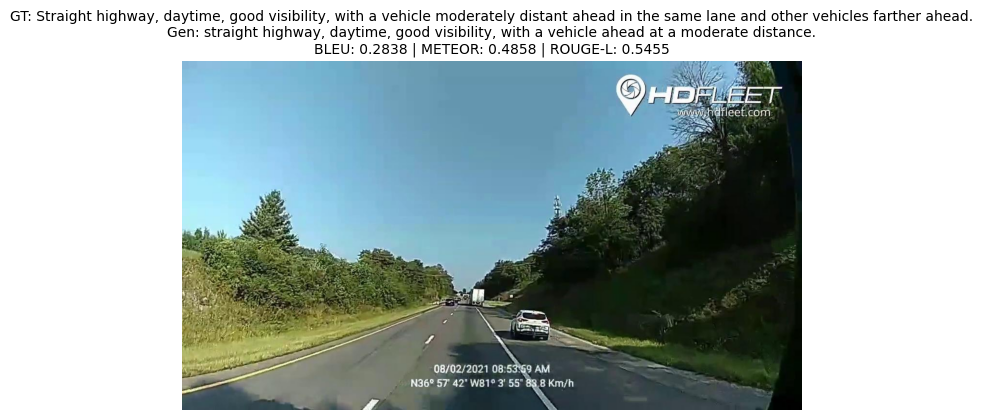

Evaluating Images:   5%|▌         | 1/20 [00:01<00:26,  1.37s/it]


Filename: video_0032_frame_0003.jpg
Ground Truth: Straight road through a rural area, daytime with overcast skies and moderate visibility, with a vehicle moderately distant ahead.
Generated: straight highway, daytime, good visibility, with a vehicle ahead at a moderate distance.
BLEU: 0.1349 | METEOR: 0.2606 | ROUGE-L: 0.4375


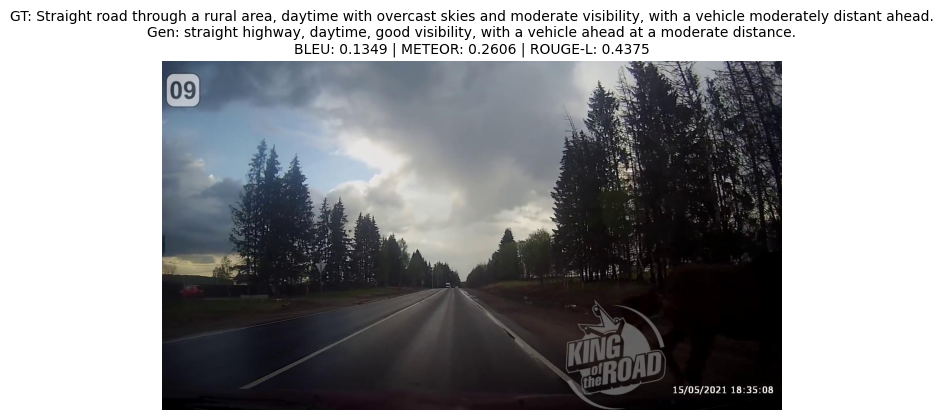

Evaluating Images:  10%|█         | 2/20 [00:03<00:34,  1.94s/it]


Filename: video_0166_frame_0000.jpg
Ground Truth: Straight city street, daytime, good visibility, several vehicles ahead at a moderate distance, and pedestrians on the left side of the road.
Generated: straight residential street, daytime, good visibility, with a vehicle ahead at a near distance and a pedestrian on the left sidewalk.
BLEU: 0.2052 | METEOR: 0.5796 | ROUGE-L: 0.6977


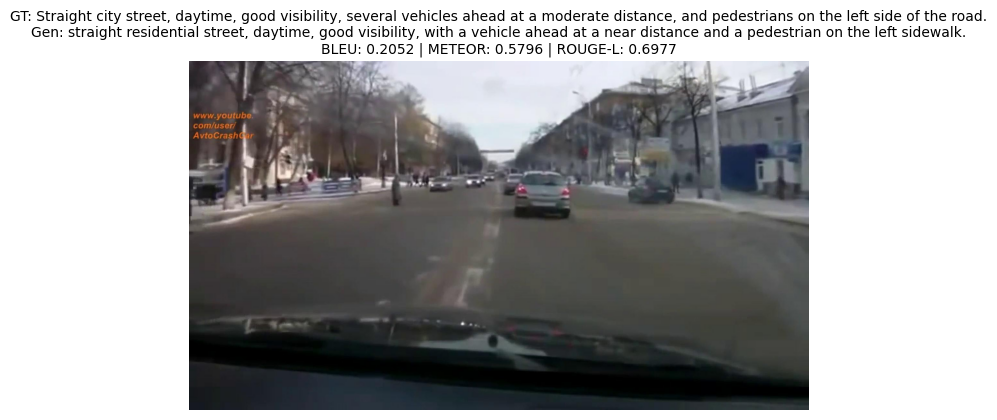

Evaluating Images:  15%|█▌        | 3/20 [00:05<00:29,  1.76s/it]


Filename: video_0073_frame_0003.jpg
Ground Truth: Straight highway, daytime, poor visibility due to heavy rain, vehicles moderately distant ahead.
Generated: straight highway, daytime, moderate visibility due to rain, with a vehicle moderately distant ahead.
BLEU: 0.1391 | METEOR: 0.8195 | ROUGE-L: 0.8148


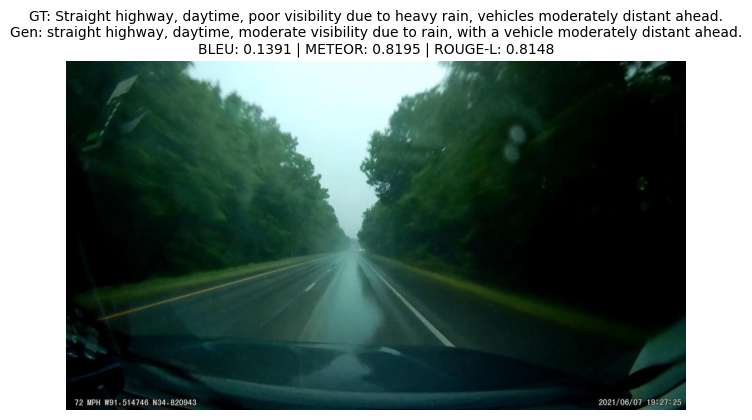

Evaluating Images:  20%|██        | 4/20 [00:06<00:25,  1.59s/it]


Filename: video_0175_frame_0010.jpg
Ground Truth: Straight city road, daytime, moderate visibility, traffic light ahead with red signal, pedestrians on the left crossing the street at near distance.
Generated: straight city street, daytime, good visibility, with a vehicle to the left and a pedestrian on the right at a near distance.
BLEU: 0.0370 | METEOR: 0.4929 | ROUGE-L: 0.5000


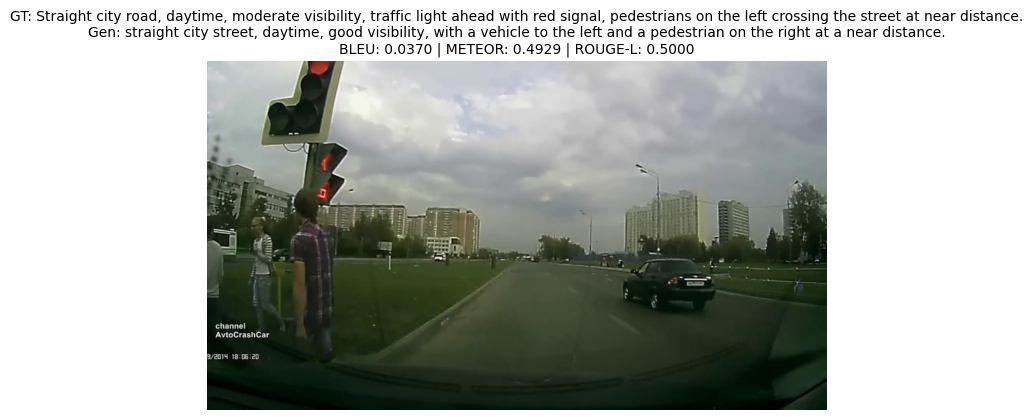

Evaluating Images:  25%|██▌       | 5/20 [00:08<00:24,  1.61s/it]


Filename: video_0124_frame_0010.jpg
Ground Truth: Straight rural road, daytime, poor visibility due to heavy fog, no visible vehicles or obstacles nearby.
Generated: straight rural road, nighttime, poor visibility due to rain, with a vehicle visible in the distance ahead.
BLEU: 0.1769 | METEOR: 0.5345 | ROUGE-L: 0.4848


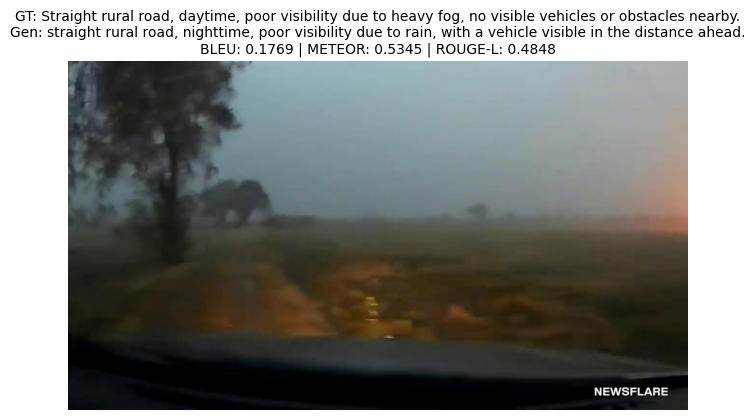

Evaluating Images:  30%|███       | 6/20 [00:10<00:23,  1.70s/it]


Filename: video_0117_frame_0004.jpg
Ground Truth: Straight highway, daytime, poor visibility due to heavy rain, large truck on the left and a pedestrian directly ahead.
Generated: straight highway, nighttime, poor visibility due to rain, vehicle ahead at a near distance.
BLEU: 0.1431 | METEOR: 0.4054 | ROUGE-L: 0.4848


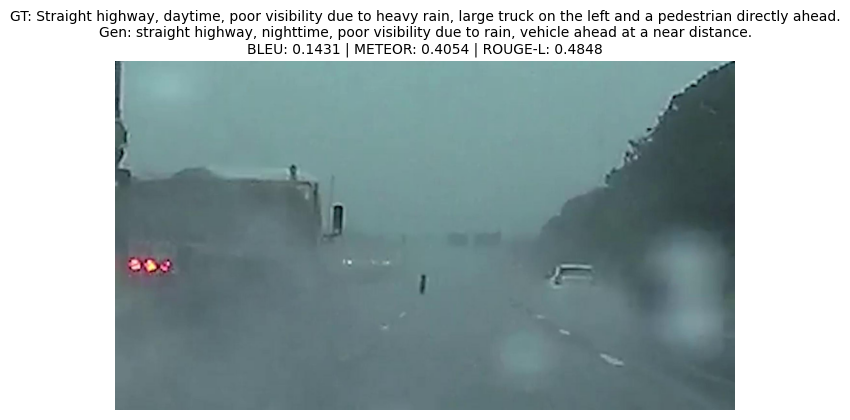

Evaluating Images:  35%|███▌      | 7/20 [00:11<00:20,  1.60s/it]


Filename: video_0155_frame_0009.jpg
Ground Truth: Straight city street, daytime, good visibility, a pedestrian is walking on the left sidewalk, with a vehicle directly ahead.
Generated: straight road, daytime, good visibility, with a vehicle ahead at a near distance and a pedestrian on the left sidewalk.
BLEU: 0.1187 | METEOR: 0.5352 | ROUGE-L: 0.5128


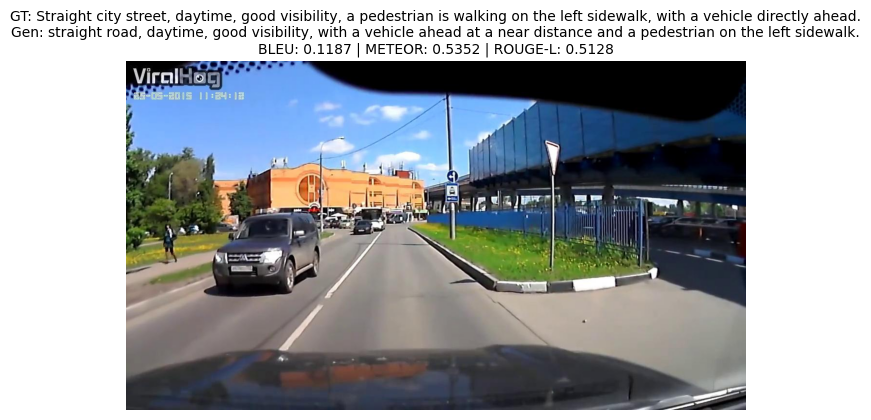

Evaluating Images:  40%|████      | 8/20 [00:12<00:17,  1.49s/it]


Filename: video_0192_frame_0002.jpg
Ground Truth: Straight residential street, daytime, good visibility. Pedestrians crossing the street ahead at a near distance.
Generated: straight residential street, daytime, good visibility, with a pedestrian crossing the street at a near distance.
BLEU: 0.3767 | METEOR: 0.8556 | ROUGE-L: 0.9032


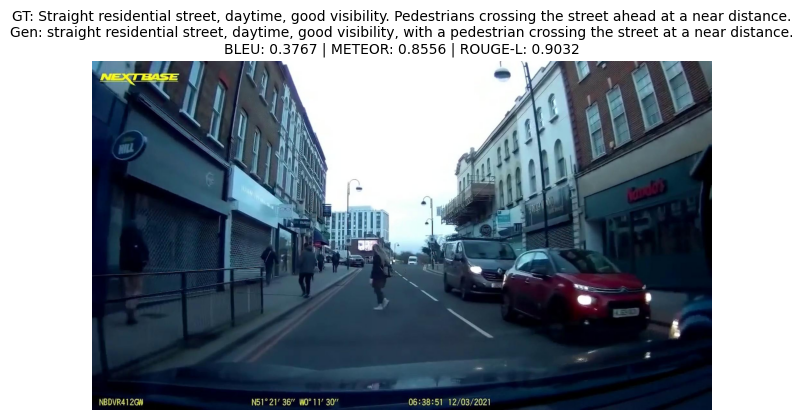

Evaluating Images:  45%|████▌     | 9/20 [00:14<00:17,  1.59s/it]


Filename: video_0130_frame_0002.jpg
Ground Truth: Straight residential street, daytime, good visibility, with a vehicle moderately distant ahead approaching an intersection with a green light.
Generated: straight residential street, daytime, good visibility, a vehicle is moderately distant ahead, and a pedestrian is on the left sidewalk.
BLEU: 0.2359 | METEOR: 0.5621 | ROUGE-L: 0.6154


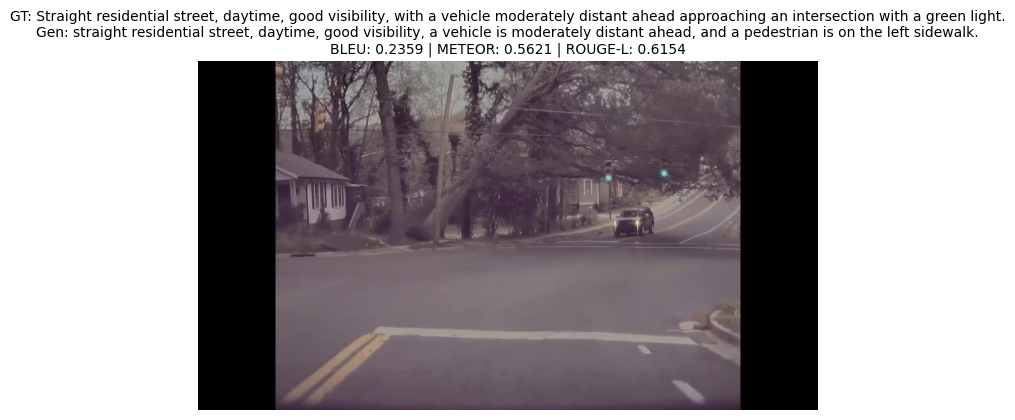

Evaluating Images:  50%|█████     | 10/20 [00:15<00:15,  1.54s/it]


Filename: video_0194_frame_0003.jpg
Ground Truth: Straight highway, daytime, good visibility, distant vehicles ahead, a truck is stopped to the right with two pedestrians nearby.
Generated: straight city street, daytime, good visibility, with a vehicle ahead at a moderate distance and a pedestrian on the left sidewalk.
BLEU: 0.0538 | METEOR: 0.3585 | ROUGE-L: 0.4000


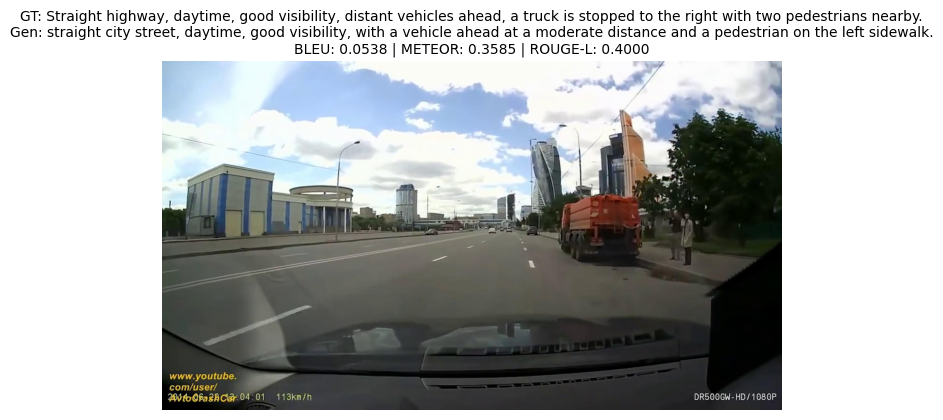

Evaluating Images:  55%|█████▌    | 11/20 [00:17<00:13,  1.53s/it]


Filename: video_0078_frame_0003.jpg
Ground Truth: Straight city street, daytime with snow, moderate visibility, vehicles ahead at a moderate distance, a tire in the street on the left is an obstacle.
Generated: straight residential street, daytime, moderate visibility, with several vehicles ahead at a near distance and a pedestrian on the left sidewalk.
BLEU: 0.1628 | METEOR: 0.4669 | ROUGE-L: 0.6087


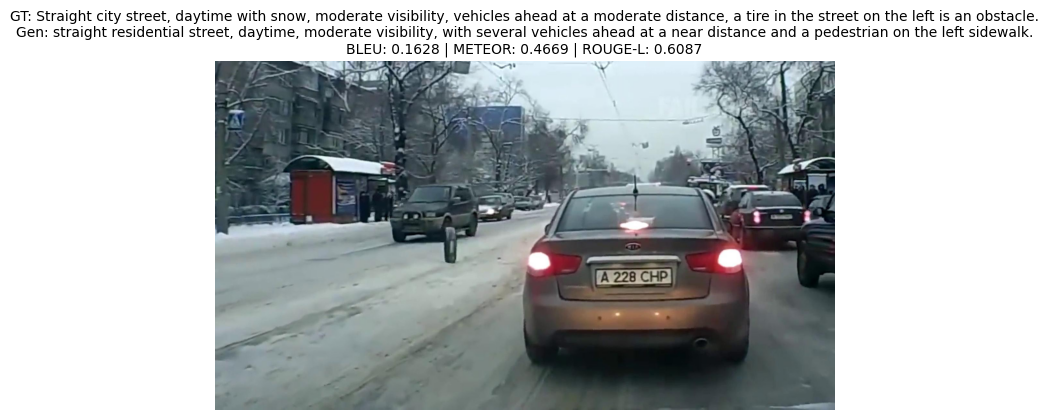

Evaluating Images:  60%|██████    | 12/20 [00:18<00:11,  1.50s/it]


Filename: video_0072_frame_0003.jpg
Ground Truth: Straight highway, daytime, good visibility, there is a large piece of debris directly ahead and a vehicle at a near distance to the right.
Generated: straight highway, daytime, good visibility, vehicle ahead at a near distance, with a pedestrian on the left side of the road.
BLEU: 0.1631 | METEOR: 0.4575 | ROUGE-L: 0.4889


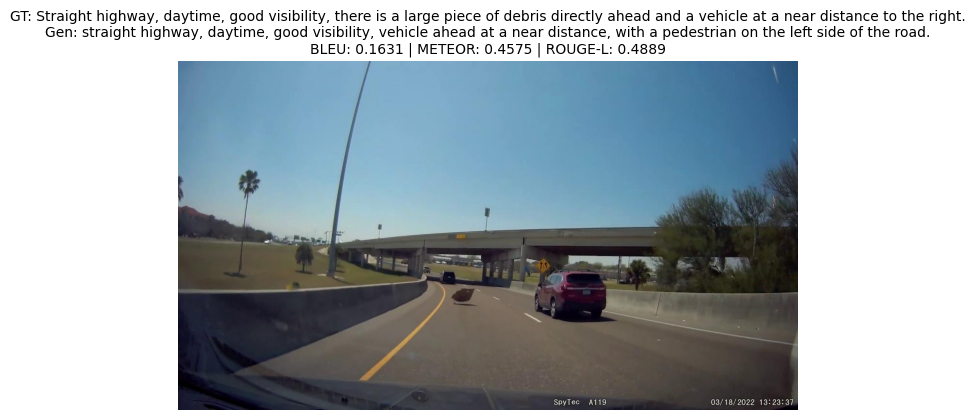

Evaluating Images:  65%|██████▌   | 13/20 [00:20<00:10,  1.56s/it]


Filename: video_0063_frame_0002.jpg
Ground Truth: Straight highway, daytime, good visibility, vehicles far away ahead.
Generated: straight rural road, daytime, good visibility, with a white car moderately distant ahead and a tire on the right side of the road.
BLEU: 0.0410 | METEOR: 0.3606 | ROUGE-L: 0.3125


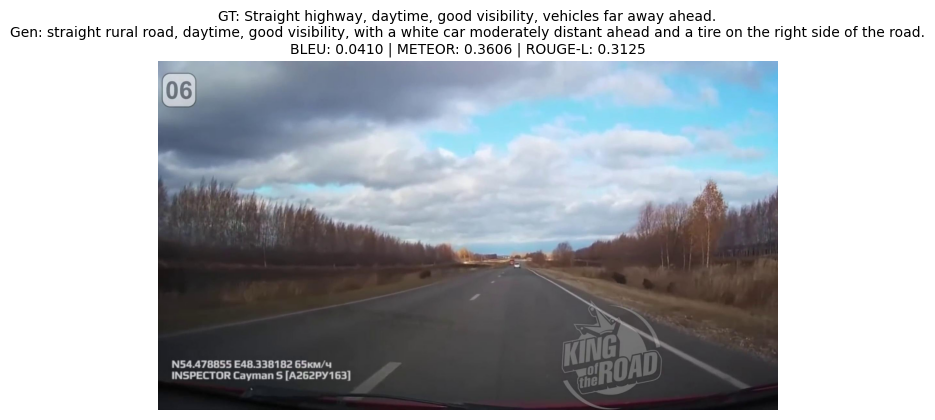

Evaluating Images:  70%|███████   | 14/20 [00:22<00:10,  1.68s/it]


Filename: video_0001_frame_0004.jpg
Ground Truth: Straight residential street, daytime, with good visibility, cars parked on both sides, zebra crossing ahead with a pedestrian on the right side and a cat on the left side.
Generated: straight residential street, daytime, moderate visibility, with a zebra crossing ahead and parked vehicles on the right side.
BLEU: 0.0781 | METEOR: 0.5035 | ROUGE-L: 0.5106


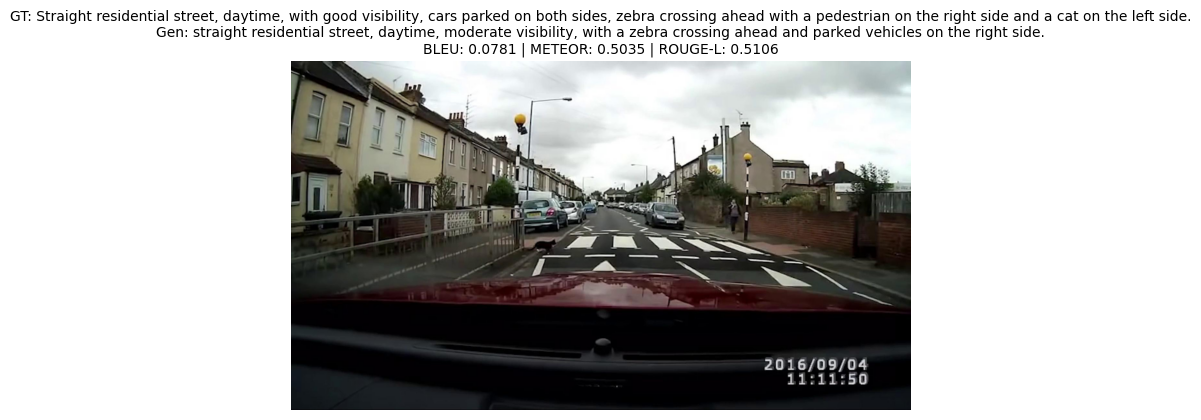

Evaluating Images:  75%|███████▌  | 15/20 [00:24<00:08,  1.63s/it]


Filename: video_0099_frame_0006.jpg
Ground Truth: Straight highway, daytime, good visibility, there is a truck with a trailer that stopped on the right lane, debris on the road.
Generated: straight highway, daytime, good visibility, with a van to the right and a car ahead at a moderate distance.
BLEU: 0.1506 | METEOR: 0.4111 | ROUGE-L: 0.4390


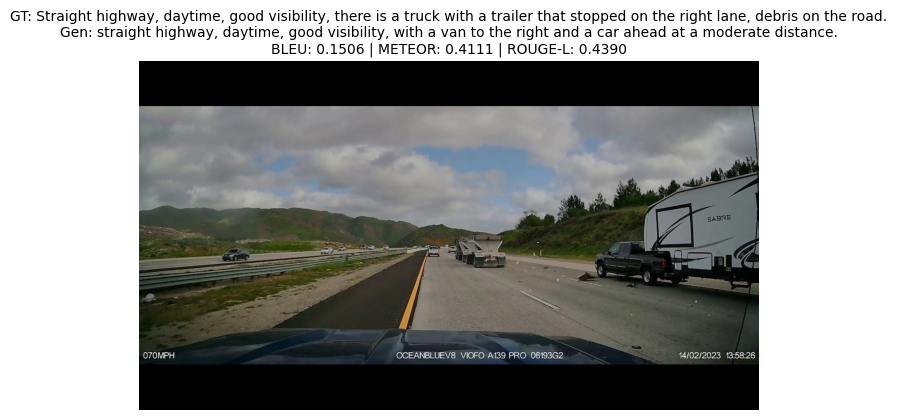

Evaluating Images:  80%|████████  | 16/20 [00:46<00:31,  7.99s/it]


Filename: video_0198_frame_0006.jpg
Ground Truth: Straight residential street, daytime, good visibility, vehicle parked closely on the left, another vehicle on the right.
Generated: straight residential street, daytime, good visibility, with a parked vehicle on the right side of the road at a near distance.
BLEU: 0.2404 | METEOR: 0.6466 | ROUGE-L: 0.5789


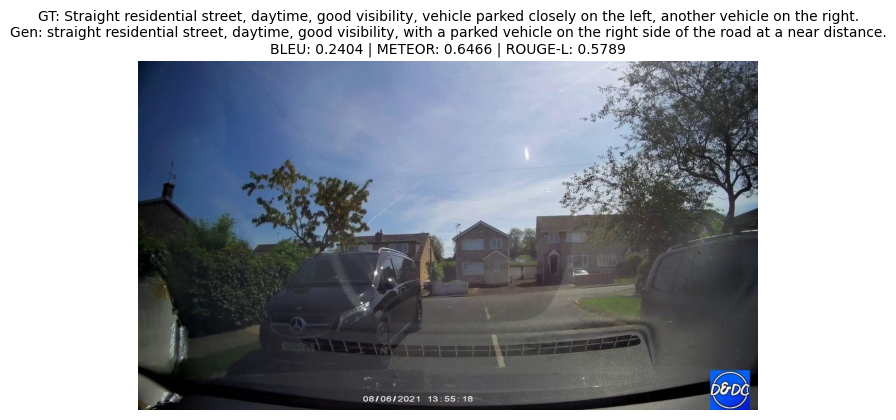

Evaluating Images:  85%|████████▌ | 17/20 [00:48<00:17,  5.95s/it]


Filename: video_0137_frame_0001.jpg
Ground Truth: Straight highway, daytime, good visibility, several moderately distant vehicles ahead, construction cones on the right side.
Generated: straight highway, daytime, good visibility, with several vehicles ahead at a moderate distance.
BLEU: 0.1699 | METEOR: 0.4777 | ROUGE-L: 0.5517


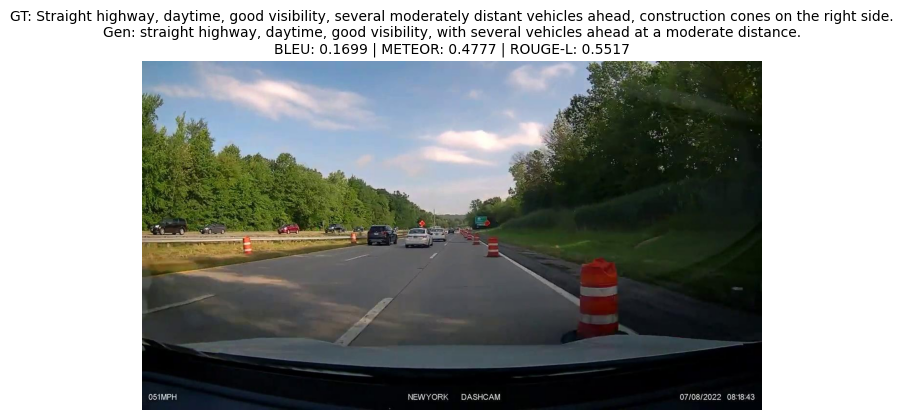

Evaluating Images:  90%|█████████ | 18/20 [00:48<00:08,  4.41s/it]


Filename: video_0039_frame_0006.jpg
Ground Truth: Straight residential street, daytime, good visibility, with a turtle directly in front of the vehicle.
Generated: straight residential street, daytime, good visibility, a small toy dog is in the middle of the road at a near distance.
BLEU: 0.2082 | METEOR: 0.6205 | ROUGE-L: 0.5556


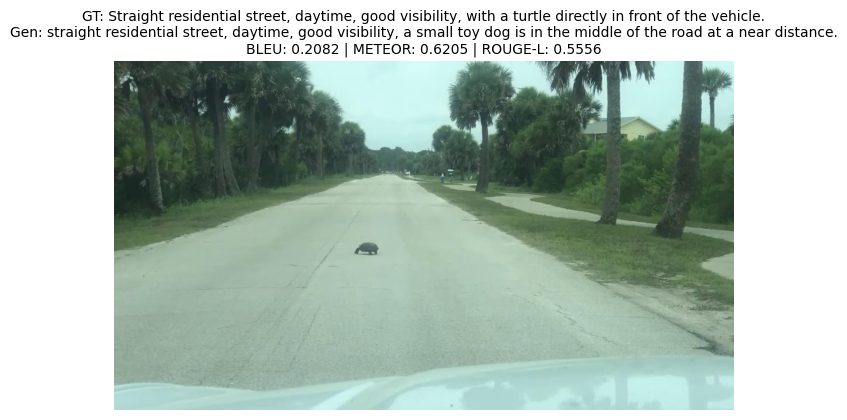

Evaluating Images:  95%|█████████▌| 19/20 [00:50<00:03,  3.48s/it]


Filename: video_0171_frame_0000.jpg
Ground Truth: Straight residential street, daytime, good visibility; pedestrians are visible on the left at a moderate distance and a zebra crossing is directly ahead.
Generated: straight residential street, daytime, good visibility, with a vehicle ahead at a moderate distance and a pedestrian on the left sidewalk.
BLEU: 0.3627 | METEOR: 0.6517 | ROUGE-L: 0.5455


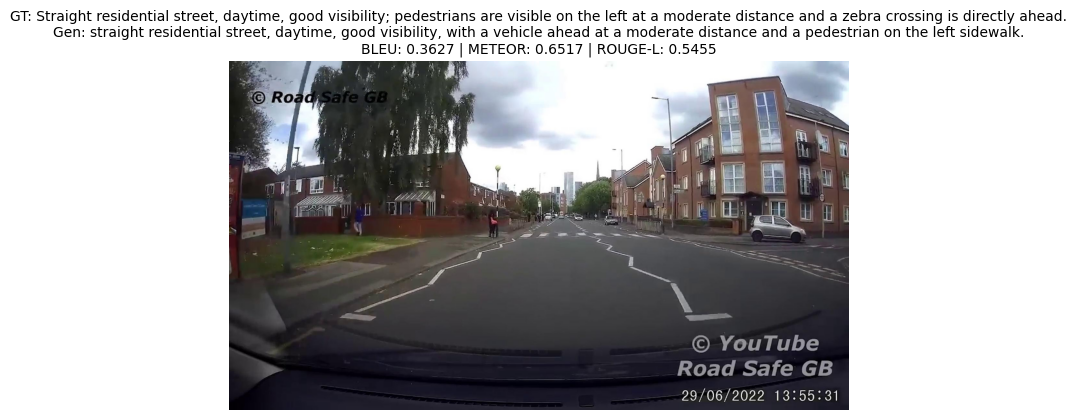

Evaluating Images: 100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


--- Evaluation Summary ---
Corpus BLEU Score: 0.2036
Average METEOR Score: 0.5243
Average ROUGE-L Score: 0.5494


In [ ]:
# Set your evaluation paths
IMAGE_FOLDER = "/content/drive/MyDrive/Gemini_Captions/kg_test_images"  # Folder containing images for evaluation
CAPTIONS_FILE = "/content/drive/MyDrive/Gemini_Captions/kg_test.json"  # Ground truth captions JSON file
MODEL_CHECKPOINT_PATH = "/content/drive/MyDrive/gemini_models/blip_checkpoints_17_04/blip-epoch=02-val_loss=0.0536.ckpt"  # Fine-tuned BLIP checkpoint path

# Run evaluation on a specified number of images (e.g., max_images=10)
evaluate_model(IMAGE_FOLDER,CAPTIONS_FILE,MODEL_CHECKPOINT_PATH ,max_images=20)